# Intro
Voy a hacer un proyecto basico basado en la competicion de Kaggle [Give Me Some Credit](https://www.kaggle.com/competitions/GiveMeSomeCredit/data) donde lo que buscamos es predecir la probabilidad de que alguien muestre estres financiero en los proximos dos años.

# Imports

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load
Vamos a cargar los archivos que tenemos para ver siquiera que pinta tienen. Los archivos que venian acompañados de la competicion son:
    - rejected: Tenemos informacion sobre los creditos que fueron rechazados
    - acepted: Informacion sobre los creditos que fueron aceptados


In [108]:
df_test = pd.read_csv("../data/raw/cs-test.csv")
df_train = pd.read_csv("../data/raw/cs-training.csv")
data_dictionary = pd.read_excel("../data/raw/Data Dictionary.xlsx",sheet_name=0,header=1)

# EDA

## Target separation
Vamos a quedarnos por un lado con el target que es el vector de si la gente entro en riesgo, que es SeriousDlqin2yrs

In [109]:
y_train = df_train["SeriousDlqin2yrs"]
y_train

0         1
1         0
2         0
3         0
4         0
         ..
149995    0
149996    0
149997    0
149998    0
149999    0
Name: SeriousDlqin2yrs, Length: 150000, dtype: int64

## Variable description

In [110]:
print(data_dictionary.to_markdown())

|    | Variable Name                        | Description                                                                                                                                              | Type       |
|---:|:-------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------|
|  0 | SeriousDlqin2yrs                     | Person experienced 90 days past due delinquency or worse                                                                                                 | Y/N        |
|  1 | RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
|  2 | age                                  | Age of borrower in years                                                                          

## Some cleaning
Sacamos la columna que no sirve

In [111]:
df_train.drop(df_train[['Unnamed: 0']],axis=1,inplace=True)

## Describe

In [112]:
df_train.loc[:,df_train.columns != 'SeriousDlqin2yrs'].describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [113]:
df_train.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

## Chequemos nulos

In [114]:
df_train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

Veo que hay muchos nulos en el caso del 

## Exploracion del target

### Clase a predecir

Veamos que tan desbalanceado esta el problema

In [115]:
df_train.SeriousDlqin2yrs.value_counts()/len(df_train)*100

SeriousDlqin2yrs
0    93.316
1     6.684
Name: count, dtype: float64

Es un problema totalmente desbalanceado, donde tenemos solo un 6% de la clase positiva. Por lo tanto tendremos que tener cuidado tanto a la hora de entrenar como de predecir y entender

Recordemos de lo que vimos antes que tenemos una buena cantidad de nulos, como es la distribucion de las clases a predecir cuando el income es nullo?

In [116]:
df_train[df_train["MonthlyIncome"].isnull()].SeriousDlqin2yrs.value_counts()/len(df_train[df_train["MonthlyIncome"].isnull()])*100

SeriousDlqin2yrs
0    94.386331
1     5.613669
Name: count, dtype: float64

Y con respecto al total de los datos?

In [117]:
df_train[df_train["MonthlyIncome"].isnull()].SeriousDlqin2yrs.value_counts()/len(df_train)*100

SeriousDlqin2yrs
0    18.708000
1     1.112667
Name: count, dtype: float64

Y si sumamos income 0?

In [118]:
df_train[(df_train['MonthlyIncome']==0) | (df_train['MonthlyIncome'].isna())].SeriousDlqin2yrs.value_counts()/len(df_train)*100

SeriousDlqin2yrs
0    19.753333
1     1.156667
Name: count, dtype: float64

Aca tenemos que hacer un salto de fe importante con respecto al income. Y es que estamos hablando del contexto de riesgo crediticio y ademas una de las features que tenemos es _DebtIncome_, lo cual esta definido como el cociente entre la deuda y el income por lo que no deberia ser posible tener montos = 0, y en el caso de los monton nullos uno podria tratar de imputarlos de alguna manera, sin embargo como no tenemos el dato de la dueda que se usa para calcular el ratio no podemos inferir el income. Por lo que lo que vamos a hacer es dropear de nuestro entrenamiento este tipo de registros

In [119]:
df_train.drop(df_train[df_train['MonthlyIncome'].isna()==True].index,inplace=True)

In [120]:
df_train.drop(df_train[df_train['MonthlyIncome']==0].index,inplace=True)

In [121]:
df_train.SeriousDlqin2yrs.value_counts()

SeriousDlqin2yrs
0    110344
1      8291
Name: count, dtype: int64

In [122]:
df_train.SeriousDlqin2yrs.value_counts()/len(df_train)*100

SeriousDlqin2yrs
0    93.011337
1     6.988663
Name: count, dtype: float64

# Feature importance?

In [133]:
X = df_train.drop('SeriousDlqin2yrs',axis = 1)
y = df_train['SeriousDlqin2yrs']

In [138]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y, random_state=0)
pd.Series(mi, index=X.columns).sort_values(ascending=False)

RevolvingUtilizationOfUnsecuredLines    0.035077
NumberOfTimes90DaysLate                 0.030259
NumberOfTime30-59DaysPastDueNotWorse    0.027442
NumberOfTime60-89DaysPastDueNotWorse    0.019255
NumberRealEstateLoansOrLines            0.006957
age                                     0.006235
NumberOfOpenCreditLinesAndLoans         0.004107
DebtRatio                               0.003962
MonthlyIncome                           0.003398
NumberOfDependents                      0.002316
dtype: float64

<Axes: >

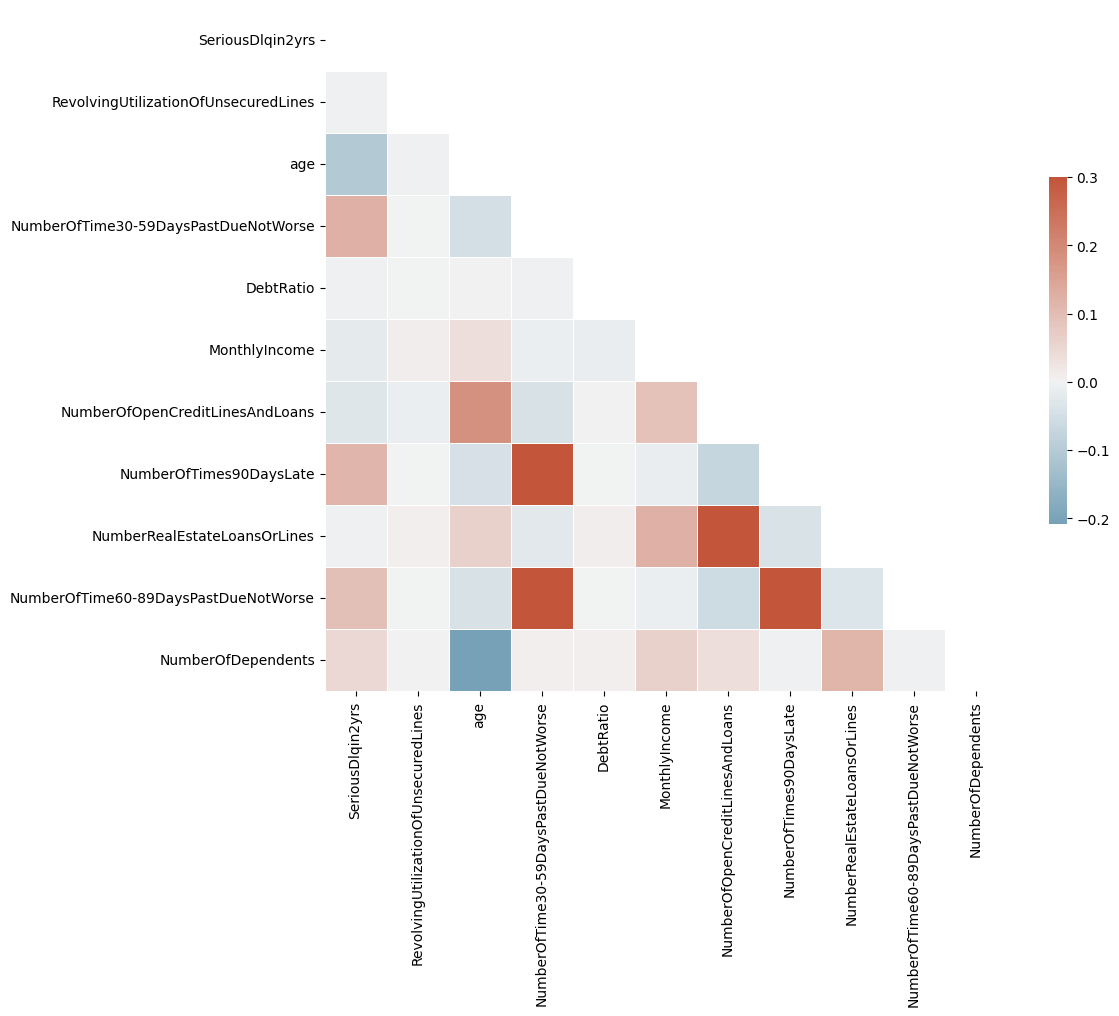

In [130]:
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Outliers?

## Clasical IQR outliers detection
Works well for univariable outliers indentification, but what im going to do? Im just going to iteratly going to purge point from each feature? The problem with this aproach is that doing this im modifiying the othre features disribution so what was consireder an outliers it might not be in the future.

In [124]:
def get_iqr_info(df: pd.DataFrame, column: str):
    """
    Calculate and print the IQR, Q1, and Q3 for a given column in a DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    column : str
        Column name to analyze.
    
    Returns
    -------
    dict
        A dictionary containing Q1, Q3, IQR, lower bound, and upper bound for outlier detection.
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    print(f"Feature: {column}")
    print(f"Q1 (25th percentile): {q1:.4f}")
    print(f"Q3 (75th percentile): {q3:.4f}")
    print(f"IQR: {iqr:.4f}")
    print(f"Lower bound (outlier threshold): {lower_bound:.4f}")
    print(f"Upper bound (outlier threshold): {upper_bound:.4f}")
    print(f"Potential outliers: {( (df[column] < lower_bound) | (df[column] > upper_bound) ).sum()}")
    
    return {
        "Q1": q1,
        "Q3": q3,
        "IQR": iqr,
        "Lower Bound": lower_bound,
        "Upper Bound": upper_bound
    }


In [125]:
df_columns = df_train.columns

In [126]:
for column in df_train.columns:
    get_iqr_info(df_train,column)
    print("\n")

Feature: SeriousDlqin2yrs
Q1 (25th percentile): 0.0000
Q3 (75th percentile): 0.0000
IQR: 0.0000
Lower bound (outlier threshold): 0.0000
Upper bound (outlier threshold): 0.0000
Potential outliers: 8291


Feature: RevolvingUtilizationOfUnsecuredLines
Q1 (25th percentile): 0.0354
Q3 (75th percentile): 0.5802
IQR: 0.5448
Lower bound (outlier threshold): -0.7818
Upper bound (outlier threshold): 1.3973
Potential outliers: 538


Feature: age
Q1 (25th percentile): 41.0000
Q3 (75th percentile): 61.0000
IQR: 20.0000
Lower bound (outlier threshold): 11.0000
Upper bound (outlier threshold): 91.0000
Potential outliers: 170


Feature: NumberOfTime30-59DaysPastDueNotWorse
Q1 (25th percentile): 0.0000
Q3 (75th percentile): 0.0000
IQR: 0.0000
Lower bound (outlier threshold): 0.0000
Upper bound (outlier threshold): 0.0000
Potential outliers: 20103


Feature: DebtRatio
Q1 (25th percentile): 0.1415
Q3 (75th percentile): 0.4733
IQR: 0.3318
Lower bound (outlier threshold): -0.3562
Upper bound (outlier thres

## Isolation forest
Machine learning based anomaly detection, works good when we have mixed data types (categorical, continuos,discrete,ordinal etc)

In [ ]:
from sklearn.ensemble import IsolationForest

def detect_outliers_iforest(df, cols, contamination=0.05, random_state=42):
    iso = IsolationForest(contamination=contamination, random_state=random_state)
    preds = iso.fit_predict(df[cols])
    return pd.DataFrame({
        "Anomaly_Score": iso.decision_function(df[cols]),
        "Outlier": preds == -1
    }, index=df.index)

## Mahalanobis Distance
The Mahalanobis distance is the distance of the test point from the center of mass divided by the width of the ellipsoid in the direction of the test point. This looks more promising as a clasical method to detect outliers

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

def multivariate_outliers_mahalanobis(df, cols, alpha=0.001):
    X = df[cols]
    X_centered = X - X.mean()
    cov = np.cov(X_centered, rowvar=False)
    inv_cov = np.linalg.inv(cov)
    
    # Mahalanobis distance
    md = np.sqrt(np.diag(X_centered @ inv_cov @ X_centered.T))
    
    # Chi-square threshold
    threshold = np.sqrt(chi2.ppf((1 - alpha), df=len(cols)))
    outliers = md > threshold
    
    return pd.DataFrame({
        "Mahalanobis_Distance": md,
        "Outlier": outliers
    }, index=df.index)


## Consensus
We treat outliers has the consensus on both megalanobis and isolation forest

# Modeling

Bien, ya tengo ubicados los posibles outliners para cada 